In [1]:
import numpy as np
import pysindy as ps
import h5py
from tqdm import trange
from sklearn.linear_model import LinearRegression
import func_timeout
import warnings
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
warnings.filterwarnings("ignore", category=UserWarning)

### Load in training data and preprocess

In [2]:
n_data = 3000
d = h5py.File("data\\ref_data_train.jld", "r")
ref_data = d['ref_data_train'][:]
ref_params = d['ref_params_train'][:]
t = d['times_train'][:]
times = t.copy()
dt = 60

In [4]:
ref_param = np.empty((len(ref_params), 9))
for i in range(len(ref_params)):
    for j in range(9):
        ref_param[i,j] = ref_params[i][j]
ref_params = ref_param

In [6]:
EO = 1.48
ref_data[:,:,5] = EO * ref_data[:,:,5]

### PCA

In [7]:
# Importing standardscalar module 
from sklearn.preprocessing import StandardScaler
  
scalar = StandardScaler(with_std=False)
reshaped_data = np.concatenate([ref_data[i] for i in range(ref_data.shape[0])])
# fitting
scalar.fit(reshaped_data)
scaled_data = scalar.transform(reshaped_data)



# Importing PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(scaled_data)
x_pca = [pca.transform(scaled_data[i*48: i*48+48, :]) for i in range(ref_data.shape[0])]
x = np.concatenate(x_pca)

In [8]:
sum(pca.explained_variance_ratio_)

0.9996852283064148

In [9]:
data = x_pca

### Construct libraries for E-SINDy

In [12]:
### define function for hv and emission along time
def hv_func(hv_shift, t):
    hv_1 = max(np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2), 0)
    hv_2 = max((np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2)+1.0)/2, 0)
    return np.array([hv_1 * 0.9 + hv_2 * 0.1])

def emission_func(const, init_shift, t):
    return 0.95*const + 0.05*const*np.sin((t +1500) /(1440/2)*np.pi - init_shift)

In [13]:
depositions =     np.array([-0.4/(100*12) * 60, 
    -4/(100*15)* 60,
    -0.5/(100*2) * 60,
    -0.1/(100*2) * 60,
    -0.03/2 * 60,
    -0.1/100 * 60]).reshape(1,6)

In [14]:
# Combine control variables with data
multi_U = []
for i in range(n_data):
    p = np.repeat(ref_params[i,0], t.shape[0])
    T = np.repeat(ref_params[i,1], t.shape[0])
    Tp =p*T
    depo = np.repeat(depositions, t.shape[0], axis=0)
    hv = np.concatenate([hv_func( ref_params[i,-1], ti) for ti in t-1500])
    emission1 = 0.001 * np.stack([emission_func( ref_params[i,2], ref_params[i,5], ti) for ti in t-1500])
    emission2 = 0.1 * np.stack([emission_func( ref_params[i,3],  ref_params[i,6], ti) for ti in t-1500])
    emission3 = 0.001 * np.stack([emission_func( ref_params[i,4],  ref_params[i,7], ti) for ti in t-1500])
    multi_U.append(np.hstack((emission1.reshape(-1,1), emission2.reshape(-1,1), emission3.reshape(-1,1), depo, hv.reshape(-1,1), Tp.reshape(-1,1))))

# Custome library for U
poly_library = ps.PolynomialLibrary(degree=4, include_bias=False)
library_functions = [lambda x: x]
library_function_names = [
    lambda x: x
]

# lib for emissions
custom_library1 = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names
)

# lib for other parameters
custom_library2 = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names
)

inputs_temp = np.tile([i for i in range(14)], 3)
inputs_per_library = np.reshape(inputs_temp, (3, 14))
inputs_per_library[0, 3:] = 2
inputs_per_library[1, :3] = 3
inputs_per_library[1, 12:] = 11
inputs_per_library[2, :12] = 12
print(inputs_per_library)

tensor_array = [[1, 0, 1]]

generalized_library = ps.GeneralizedLibrary(
    [poly_library, custom_library1, custom_library2],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

feature_names = ["pc1", "pc2", "pc3", "emission_NO2", "emission_HCHO", "emission_H2O2", "depo1","depo2","depo3","depo4", "depo5", "depo6", "hv", "p*T"]
optimizer = ps.STLSQ(threshold=3.29e-5, alpha=0.01)
u = np.concatenate(multi_U)
model = ps.SINDy()
dx= np.concatenate(model.differentiate(data, t=dt, multiple_trajectories=True))
generalized_library.fit(np.hstack((x, u)))
lib = generalized_library.transform(np.hstack((x, u)))

[[ 0  1  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  4  5  6  7  8  9 10 11 11 11]
 [12 12 12 12 12 12 12 12 12 12 12 12 12 13]]


### Build functions for inference using numba for speedup

In [15]:
from numbalsoda import lsoda_sig, lsoda, dop853
import numba as nb

def make_lsoda_func(param):
    @nb.cfunc(lsoda_sig)
    def rhs(t, u, du, p):
        y = nb.carray(u, (3,))
        p_ = nb.carray(p, (8,))
        x0 = y[0]
        x1 = y[1]
        x2 = y[2]

        ## 4th order polynomial
        y_ = np.array([x0, x1, x2, x0**2, x0*x1, x0*x2, x1**2, x1*x2, x2**2, x0**3, x0**2*x1, 
              x0**2*x2, x0*x1**2, x0*x1*x2, x0*x2**2, x1**3, x1**2*x2, x1*x2**2, 
              x2**3, x0**4, x0**3*x1, x0**3*x2, x0**2*x1**2, x0**2*x1*x2, x0**2*x2**2, 
              x0*x1**3, x0*x1**2*x2, x0*x1*x2**2, x0*x2**3, x1**4, x1**3*x2, x1**2*x2**2, x1*x2**3, x2**4])
        hv_shift = p_[-1]
        hv_1 = max(np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2), 0)
        hv_2 = max((np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2)+1.0)/2, 0)
        hv = np.array([hv_1 * 0.9 + hv_2 * 0.1])

        pT = np.array([p_[6]])
        emission1 = p_[0]
        emission2 = p_[1]
        emission3 = p_[2]
        emission1_shift = p_[3]
        emission2_shift = p_[4]
        emission3_shift = p_[5]
        emission1 = 0.001* np.array([0.95*emission1 + 0.05*emission1*np.sin((t +1500) /(1440/2)*np.pi - emission1_shift)])
        emission2 = 0.1* np.array([0.95*emission2 + 0.05*emission2*np.sin((t +1500) /(1440/2)*np.pi - emission2_shift)])
        emission3 = 0.001* np.array([0.95*emission3 + 0.05*emission3*np.sin((t +1500) /(1440/2)*np.pi - emission3_shift)])
        depos = np.array([-0.4/(100*12) * 60, -4/(100*15)* 60,-0.5/(100*2) * 60,-0.1/(100*2) * 60,-0.03/2 * 60,-0.1/100 * 60])
        ## interleave combinations of hv, p, T with y_
        temp = np.empty(len(y_)*2)
        for idx, (item1, item2) in enumerate(zip(hv*y_, pT*y_)):
            temp[idx*2] = item1
            temp[idx*2+1] = item2

        θ = np.concatenate((y_, emission1,emission2, emission3, depos, hv, pT, temp))

        du[0] = np.sum(param[0,:]*θ)
        du[1] = np.sum(param[1,:]*θ)
        du[2] = np.sum(param[2,:]*θ)
    return rhs

### Prepare validation data and helper functions for metrics

In [17]:
def calc_rmse(prediction, reference):
    prediction = prediction.copy()
    reference = reference.copy()
    if len(reference.shape) == 3:
        reference[:,:,5] =  reference[:,:,5] / EO
        prediction[:,:,5] =  prediction[:,:,5] / EO
    else:
        reference[:,5] =  reference[:,5] / EO
        prediction[:,5] =  prediction[:,5] / EO
    return np.sqrt(np.mean((prediction - reference)**2))

def calc_rmse_O3(prediction, reference):
    prediction = prediction.copy()
    reference = reference.copy()
    if len(reference.shape) == 3:
        r =  reference[:,:,5] / EO
        p =  prediction[:,:,5] / EO
    else:
        r =  reference[:,5] / EO
        p =  prediction[:,5] / EO
    return np.sqrt(np.mean((p - r)**2))
def inv_transform(x):
    return scalar.inverse_transform(pca.inverse_transform(x))

In [18]:
d_validate = h5py.File("data\\ref_data_validate.jld", "r")
ref_params_validate = d_validate['ref_params_validate'][:]
ref_data_validate = d_validate['ref_data_validate'][:]
times_validate = d_validate['times_validate'][:]
ref_param = np.empty((len(ref_params_validate), 9))
for i in range(len(ref_params_validate)):
    for j in range(9):
        ref_param[i,j] = ref_params_validate[i][j]
ref_params_validate = ref_param
ref_data_validate[:,:,5] = EO * ref_data_validate[:,:,5]
multi_U_validate1 = []
    
for i in range(ref_params_validate.shape[0]):
    pT = ref_params_validate[i][0]* ref_params_validate[i][1]
    multi_U_validate1.append(np.concatenate((ref_params_validate[i][2:8], [pT], [ref_params_validate[i][-1]]), axis = 0))
reshaped_data_validate = np.concatenate([ref_data_validate[i] for i in range(ref_data_validate.shape[0])])
scaled_data_validate = scalar.transform(reshaped_data_validate)
validate_pca = [pca.transform(scaled_data_validate[i*24*9: i*24*9+24*9, :]) for i in range(375)]

In [19]:
times_validate-=1500

### Train models with different bootstrapping parameter combinations

In [20]:
from tempfile import TemporaryFile
ensemble = True
lib_ensemble = True
percentage = [0.3, 0.6, 0.9]
n_cols = [30, 60, 90]
n_features = lib.shape[1]
COEF_THRESHOLD = 1e-14
n_models = 100
import random

res = []
for per in percentage:
    for n_candidates_to_drop in n_cols:
        random.seed(42)
        np.random.seed(42)
        print((per, n_candidates_to_drop))
        print("training model....")
        n_subset = int(per * n_data * 48)
        ensemble_coef = []
        for i in trange(n_models):
            coef = np.zeros((3, n_features))
            if ensemble:
                rand_inds = np.random.choice(range(n_data * 48), n_subset, replace=False)
                lib_new = np.take(lib, rand_inds, axis=0)
                dx_new = np.take(dx, rand_inds, axis=0)
            else:
                lib_new = lib
                dx_new = dx
            if lib_ensemble:
                keep_inds = np.sort(np.random.choice(range(n_features), n_features - n_candidates_to_drop, replace=False))
                lib_new = lib_new.take(keep_inds, axis=1)
            else:
                keep_inds = range(n_features)

            optimizer.fit(lib_new, dx_new)
            coef[:, keep_inds] = optimizer.coef_
            ind_ = np.abs(coef) > COEF_THRESHOLD
            coef__ = np.zeros(coef.shape)
            for i in range(ind_.shape[0]):
                if np.any(ind_[i]):
                    coef__[i, ind_[i]] = (LinearRegression(fit_intercept=False).fit(lib[:, ind_[i]], dx[:, i]).coef_)
            ensemble_coef.append(coef__)
        print("validating model....")
        ensemble_pred_validate = []
        stable_ensemble_validate = []
        
        for k in trange(len(ensemble_coef)):
            rhs = make_lsoda_func(ensemble_coef[k])
            funcptr = rhs.address
            u0s = np.stack(validate_pca)[:,0,:]
            Us = np.stack(multi_U_validate1)
            @nb.njit(parallel=True)
            def simulate():
                sol = np.empty((375, 216, 3))
                succ = np.empty(375)
                for i in nb.prange(375):
                    u0 = u0s[i]
                    p = Us[i]
                    usol, success = lsoda(funcptr, u0, times_validate, data = p, rtol=1.0e-3, atol=1.0e-6)
                    if len(np.argwhere(np.isnan(usol)))!=0 or np.max(np.abs(usol))>5:
                        success = 0
                    sol[i] = usol
                    succ[i] = success
                return sol, succ
            sims, succ = simulate()
            ensemble_pred_validate.append(sims)
            stable_ensemble_validate.append(succ)

        print("calculating validation error....")
        mean_sims = []
        for j in trange(375):
            temp = []
            for i in range(100):
                if stable_ensemble_validate[i][j]==1:
                    if np.max(abs(ensemble_pred_validate[i][j]))<5:
                        temp.append(inv_transform(ensemble_pred_validate[i][j]))
                    else:
                        stable_ensemble_validate[i][j]=0
            mean_sims.append(np.mean(temp, axis=0))

        stable_rate = np.sum(stable_ensemble_validate)/100/375
        rmse = calc_rmse(np.stack(mean_sims), ref_data_validate)
        rmse_O3 = calc_rmse_O3(np.stack(mean_sims), ref_data_validate)
        res.append((rmse, rmse_O3, stable_rate))
        del stable_ensemble_validate
        del ensemble_pred_validate

(0.3, 30)
training model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


validating model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:41<00:00,  2.81s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 339.97it/s]


(0.3, 60)
training model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.23it/s]


validating model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:48<00:00,  2.88s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 567.82it/s]


(0.3, 90)
training model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.71it/s]


validating model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:41<00:00,  2.82s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 569.69it/s]


(0.6, 30)
training model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


validating model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:45<00:00,  2.85s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 299.91it/s]


(0.6, 60)
training model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


validating model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:10<00:00,  3.11s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 399.78it/s]


(0.6, 90)
training model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]


validating model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:06<00:00,  3.06s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 530.92it/s]


(0.9, 30)
training model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


validating model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:41<00:00,  2.81s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 347.05it/s]


(0.9, 60)
training model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


validating model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:52<00:00,  2.93s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 511.91it/s]


(0.9, 90)
training model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.93it/s]


validating model....


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:51<00:00,  2.92s/it]


calculating validation error....


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 594.29it/s]


In [2]:
### Load in saved results
with open("result\\bootstrap_param_tuning.npy", 'rb') as f:
        res = np.load(f)

### Process results and generate plots

In [4]:
RMSE = np.array([x[0] for x in res]).reshape(3,3)
RMSE_imp = (RMSE - np.min(RMSE))/np.min(RMSE) *100
RMSE_O3 = np.array([x[1] for x in res]).reshape(3,3)
RMSE_O3_imp = (RMSE_O3 - np.min(RMSE_O3))/np.min(RMSE_O3) *100
Stable_rate = np.array([x[2] for x in res]).reshape(3,3) * 100

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_error_improvement(Error_imp, Error_imp_O3, Stable_rate_295, x_labels, num_columns):
#     sns.set(font_scale=0.8)
    Error_imp[[0, 2]] = Error_imp[[2, 0]]
    Error_imp_O3[[0, 2]] = Error_imp_O3[[2, 0]]
    Stable_rate_295[[0, 2]] = Stable_rate_295[[2, 0]]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (8,2))
    plt.subplots_adjust(wspace = 0.3)
    
    vmin = min(np.min(Error_imp), np.min(Error_imp_O3))
    vmax = max(np.max(Error_imp), np.max(Error_imp_O3))
    sns.heatmap(Error_imp, ax=ax1,cmap="viridis", annot=True, fmt=".3f", vmin=vmin , vmax=vmax, center = vmin, cbar_kws={'label': 'Original species RMSE (ppm)'})
    sns.heatmap(Error_imp_O3, ax=ax2,yticklabels=False, cmap="viridis", annot=True, fmt=".3f", vmin=vmin, vmax=vmax, center = vmin, cbar_kws={'label': 'Ozone RMSE (ppm)'})
    sns.heatmap(Stable_rate_295, ax=ax3, yticklabels=False, cmap="plasma", annot=True, fmt=".0f", cbar_kws={'label': 'Stable solution rate (%)'})

    ax1.set_ylabel("Fraction of data points sampled")
    ax2.set_xlabel("Number of dropped equation library terms out of "+str(num_columns))
    ax1.set_xticklabels(x_labels)
    ax2.set_xticklabels(x_labels)
    ax3.set_xticklabels(x_labels)
    ax1.set_yticklabels([90, 60, 30])
    ax1.set_title("(a)")
    ax2.set_title("(b)")
    ax3.set_title("(c)")
    plt.savefig('figure\\bootstrap_tuning.svg', format='svg', dpi=1200, bbox_inches="tight")

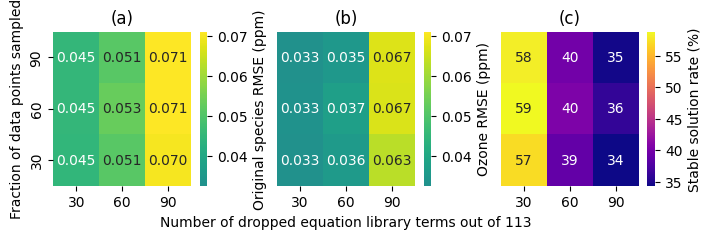

In [9]:
plot_error_improvement(RMSE, RMSE_O3, Stable_rate, [30, 60, 90], 113)

In [29]:
# np.save("result\\bootstrap_param_tuning.npy", res)